Here, all the required modules are imported. Some standard Python modules are imported. Requests, pandas and pyplot are not standard libraries and will have to be installed with pip.

In [134]:
import json, time, urllib.parse
import requests
import pandas
import matplotlib.pyplot as plt

The data which was downloaded as a CSV file is now read in. A sorted list of the article names is created so that we can collect the data from the API in a sorted manner.

In [124]:
df = pandas.read_csv('thank_the_academy.AUG.2023.csv')
article_name_list = sorted(list(df['name']))

In [ ]:
A few constants are defined that make it easier to access certain values to enhance readability. 

In [125]:
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<anair4@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = article_name_list

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_DESKTOP_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set
    "end":         "2023093000"    # this is likely the wrong end date
}

ARTICLE_PAGEVIEWS_MOBILE_WEB_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-web",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set
    "end":         "2023093000"    # this is likely the wrong end date
}

ARTICLE_PAGEVIEWS_MOBILE_APP_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-app",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set
    "end":         "2023093000"    # this is likely the wrong end date
}


The request_pageviews_per_article is a function that creates a request by combining the endpoint url with the parameters for the request.

In [126]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(request_template,
                                  article_title = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  headers = REQUEST_HEADERS
                                  ):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe='')
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

The function is called for the desktop access type. The movies are stored in a list which is iterated through. The pageviews for each movie are collected using the function created above and compiled into a single structure.

In [127]:
## for desktop
views = {'items':[]}
for i in range(0, len(ARTICLE_TITLES)):
    print("Getting pageview data for: ", ARTICLE_TITLES[i])
    views['items'].extend(request_pageviews_per_article(request_template = ARTICLE_PAGEVIEWS_DESKTOP_PARAMS_TEMPLATE, article_title = ARTICLE_TITLES[i])['items'])

Getting pageview data for:  12 Years a Slave (film)
Getting pageview data for:  1917 (2019 film)
Getting pageview data for:  20 Feet from Stardom
Getting pageview data for:  20,000 Leagues Under the Sea (1954 film)
Getting pageview data for:  2001: A Space Odyssey (film)
Getting pageview data for:  49th Parallel (film)
Getting pageview data for:  7 Faces of Dr. Lao
Getting pageview data for:  7th Heaven (1927 film)
Getting pageview data for:  8 Mile (film)
Getting pageview data for:  8½
Getting pageview data for:  A Beautiful Mind (film)
Getting pageview data for:  A Boy and His Dog (1946 film)
Getting pageview data for:  A Chance to Live
Getting pageview data for:  A Christmas Carol (1971 film)
Getting pageview data for:  A Close Shave
Getting pageview data for:  A Damsel in Distress (1937 film)
Getting pageview data for:  A Double Life (1947 film)
Getting pageview data for:  A Fantastic Woman
Getting pageview data for:  A Farewell to Arms (1932 film)
Getting pageview data for:  A Fis

The access field is removed from each pageview element returned by the API. The final results are dumped into a JSON file.

In [128]:
#print(json.dumps(views,indent=4))
print("Have %d months of pageview data"%(len(views['items'])))
for month in views['items']:
    del month['access']
    
with open("desktop-data.json", "w") as final:
   json.dump(views['items'], final) 

Have 128959 months of pageview data


The same process is repeated for the mobile app access type.

In [129]:
## for mobile app
views1 = {'items':[]}
for i in range(0, len(ARTICLE_TITLES)):
    print("Getting pageview data for: ", ARTICLE_TITLES[i])
    views1['items'].extend(request_pageviews_per_article(request_template = ARTICLE_PAGEVIEWS_MOBILE_APP_PARAMS_TEMPLATE, article_title = ARTICLE_TITLES[i])['items'])

Getting pageview data for:  12 Years a Slave (film)
Getting pageview data for:  1917 (2019 film)
Getting pageview data for:  20 Feet from Stardom
Getting pageview data for:  20,000 Leagues Under the Sea (1954 film)
Getting pageview data for:  2001: A Space Odyssey (film)
Getting pageview data for:  49th Parallel (film)
Getting pageview data for:  7 Faces of Dr. Lao
Getting pageview data for:  7th Heaven (1927 film)
Getting pageview data for:  8 Mile (film)
Getting pageview data for:  8½
Getting pageview data for:  A Beautiful Mind (film)
Getting pageview data for:  A Boy and His Dog (1946 film)
Getting pageview data for:  A Chance to Live
Getting pageview data for:  A Christmas Carol (1971 film)
Getting pageview data for:  A Close Shave
Getting pageview data for:  A Damsel in Distress (1937 film)
Getting pageview data for:  A Double Life (1947 film)
Getting pageview data for:  A Fantastic Woman
Getting pageview data for:  A Farewell to Arms (1932 film)
Getting pageview data for:  A Fis

The same process is repeated for the mobile web access type.

In [130]:
## for mobile web
views2 = {'items':[]}
for i in range(0, len(ARTICLE_TITLES)):
    print("Getting pageview data for: ", ARTICLE_TITLES[i])
    views2['items'].extend(request_pageviews_per_article(request_template = ARTICLE_PAGEVIEWS_MOBILE_WEB_PARAMS_TEMPLATE, article_title = ARTICLE_TITLES[i])['items'])

Getting pageview data for:  12 Years a Slave (film)
Getting pageview data for:  1917 (2019 film)
Getting pageview data for:  20 Feet from Stardom
Getting pageview data for:  20,000 Leagues Under the Sea (1954 film)
Getting pageview data for:  2001: A Space Odyssey (film)
Getting pageview data for:  49th Parallel (film)
Getting pageview data for:  7 Faces of Dr. Lao
Getting pageview data for:  7th Heaven (1927 film)
Getting pageview data for:  8 Mile (film)
Getting pageview data for:  8½
Getting pageview data for:  A Beautiful Mind (film)
Getting pageview data for:  A Boy and His Dog (1946 film)
Getting pageview data for:  A Chance to Live
Getting pageview data for:  A Christmas Carol (1971 film)
Getting pageview data for:  A Close Shave
Getting pageview data for:  A Damsel in Distress (1937 film)
Getting pageview data for:  A Double Life (1947 film)
Getting pageview data for:  A Fantastic Woman
Getting pageview data for:  A Farewell to Arms (1932 film)
Getting pageview data for:  A Fis

The pageviews returned by the API for the mobile app access type is added to the number of pageviews for the mobile web access type to create a more generic value of all mobile pageviews. The resulting dictionary is dumped into another JSON file. 

In [131]:
temp = views1
mob = []
for month in range(len(views1['items'])):
    del temp['items'][month]['access']
    temp['items'][month]['views'] = views1['items'][month]['views'] + views2['items'][month]['views']
    mob.append(temp['items'][month])

with open("mobile-data.json", "w") as final:
   json.dump(mob, final)    

To create the cumulative file, the pageviews of all 3 access types are combined. The pageviews returned by the API for the mobile app access type is added to the number of pageviews for the mobile web access type and the number of pageviews for the desktop access type. The resulting dictionary is dumped into the third JSON file.

In [133]:
temp = views1
cumulative = []
for month in range(len(views1['items'])):
    temp['items'][month]['views'] = views1['items'][month]['views'] + views2['items'][month]['views'] + views['items'][month]['views']
    cumulative.append(temp['items'][month])

with open("cumulative-data.json", "w") as final:
   json.dump(cumulative, final)  

The JSON files are read and and the data is converted into a dataframe which makes it easier to use and visualize.

In [190]:
with open('desktop-data.json', 'r') as desktop:
    desktop_data = json.load(desktop)

desktop_df = pandas.DataFrame(desktop_data)
desktop_df['timestamp'] = pandas.to_datetime(desktop_df['timestamp'],format='%Y%m%d%H')
desktop_df.head()

,project,article,granularity,timestamp,agent,views
0,en.wikipedia,12_Years_a_Slave_(film),monthly,2015-07-01,user,62693
1,en.wikipedia,12_Years_a_Slave_(film),monthly,2015-08-01,user,58902
2,en.wikipedia,12_Years_a_Slave_(film),monthly,2015-09-01,user,59116
3,en.wikipedia,12_Years_a_Slave_(film),monthly,2015-10-01,user,65535
4,en.wikipedia,12_Years_a_Slave_(film),monthly,2015-11-01,user,66646


In [192]:
with open('mobile-data.json', 'r') as mobile:
    mobile_data = json.load(mobile)

# Convert JSON data to a Pandas DataFrame
mobile_df = pandas.DataFrame(mobile_data)
mobile_df['timestamp'] = pandas.to_datetime(mobile_df['timestamp'],format='%Y%m%d%H')

,project,article,granularity,timestamp,agent,views
0,en.wikipedia,12_Years_a_Slave_(film),monthly,2015-07-01,user,75458
1,en.wikipedia,12_Years_a_Slave_(film),monthly,2015-08-01,user,64091
2,en.wikipedia,12_Years_a_Slave_(film),monthly,2015-09-01,user,53916
3,en.wikipedia,12_Years_a_Slave_(film),monthly,2015-10-01,user,61688
4,en.wikipedia,12_Years_a_Slave_(film),monthly,2015-11-01,user,61671
...,...,...,...,...,...,...
96,en.wikipedia,12_Years_a_Slave_(film),monthly,2023-07-01,user,48382
97,en.wikipedia,12_Years_a_Slave_(film),monthly,2023-08-01,user,44993
98,en.wikipedia,12_Years_a_Slave_(film),monthly,2023-09-01,user,42513
99,en.wikipedia,1917_(2019_film),monthly,2019-03-01,user,1071


The objective here is to plot time series for the articles that have the highest average monthly page requests and the lowest average monthly page requests for desktop access and mobile access. The average monthly page requests are calculated for each article and the articles with the highest and lowest values are identified. A subset of the datafram containing the required values are created.

In [211]:
desktop_average_data = desktop_df.groupby(['article'])['views'].mean().reset_index()
mobile_average_data = mobile_df.groupby(['article'])['views'].mean().reset_index()

max_desktop = desktop_average_data.loc[desktop_average_data['views'].idxmax()]
min_desktop = desktop_average_data.loc[desktop_average_data['views'].idxmin()]
max_mobile = mobile_average_data.loc[mobile_average_data['views'].idxmax()]
min_mobile = mobile_average_data.loc[mobile_average_data['views'].idxmin()]

desktop_highest_data = desktop_df[desktop_df['article']==max_desktop['article']]
desktop_lowest_data = desktop_df[desktop_df['article']==min_desktop['article']]
mobile_highest_data = mobile_df[mobile_df['article']==max_mobile['article']]
mobile_lowest_data = mobile_df[mobile_df['article']==min_mobile['article']]


In [ ]:
The timeseries of the identified movies is plotted and labelled using the pyplot library.

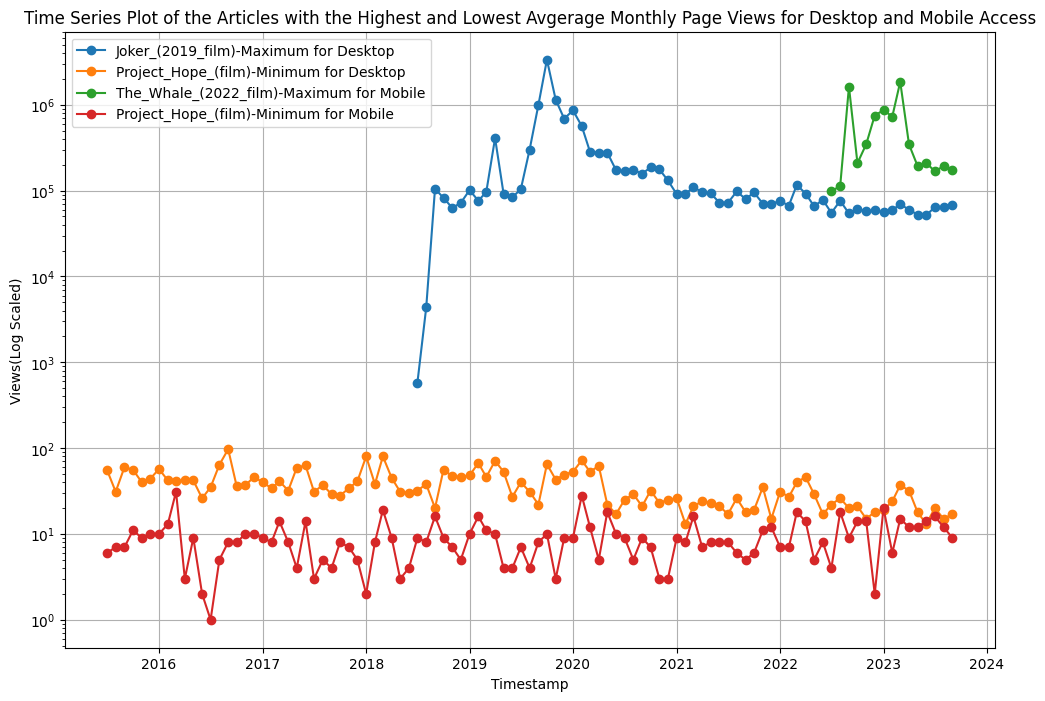

In [223]:
plt.figure(figsize=(12, 8))
label1 = max_desktop['article']
label2 = min_desktop['article']
label3 = max_mobile['article']
label4 = min_mobile['article']

plt.semilogy(desktop_highest_data['timestamp'], desktop_highest_data['views'], label=label1+'-Maximum for Desktop', marker='o')
plt.semilogy(desktop_lowest_data['timestamp'], desktop_lowest_data['views'], label=label2+'-Minimum for Desktop', marker='o')
plt.semilogy(mobile_highest_data['timestamp'], mobile_highest_data['views'], label=label3+'-Maximum for Mobile', marker='o')
plt.semilogy(mobile_lowest_data['timestamp'], mobile_lowest_data['views'], label=label4+'-Minimum for Mobile', marker='o')

plt.xlabel('Timestamp')
plt.ylabel('Views(Log Scaled)')
plt.title('Time Series Plot of the Articles with the Highest and Lowest Avgerage Monthly Page Views for Desktop and Mobile Access')
plt.legend()
plt.grid(True)

The objective here is to plot the time series for the top 10 article pages by largest (peak) page views over the entire time by access type. You first find the month for each article that contains the highest (peak) page views, and then order the articles by these peak values. The two dataframes are sorted according to the number of views and then the 10 articles with the highest views are selected for plotting.

In [220]:
sorted_desktop_views = desktop_df.sort_values(by='views',ascending = False).reset_index(drop=True)
sorted_mobile_views = mobile_df.sort_values(by='views',ascending = False).reset_index(drop=True)

desktop_top10_views = sorted_desktop_views[:10]
mobile_top10_views = sorted_mobile_views[:10]

desktop_top10_views['peak_month'] = desktop_top10_views['timestamp'].apply(lambda x: x.month)
mobile_top10_views['peak_month'] = mobile_top10_views['timestamp'].apply(lambda x: x.month)

desktop_top10_articles = desktop_top10_views['article'].tolist()
mobile_top10_articles = mobile_top10_views['article'].tolist() 

mobile_top10 = sorted_mobile_views.drop_duplicates(['article']).head(10)
mobile_top10['peak_month'] = mobile_top10['timestamp'].apply(lambda x: x.month)

mobile_top10_articles = list(mobile_top10['article'])

/var/folders/m2/gc3hzx697sqd2xsxwzcyyz0w0000gn/T/ipykernel_34360/1218652897.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desktop_top10_views['peak_month'] = desktop_top10_views['timestamp'].apply(lambda x: x.month)
/var/folders/m2/gc3hzx697sqd2xsxwzcyyz0w0000gn/T/ipykernel_34360/1218652897.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mobile_top10_views['peak_month'] = mobile_top10_views['timestamp'].apply(lambda x: x.month)


The timeseries of the identified movies is plotted and labelled using the pyplot library.

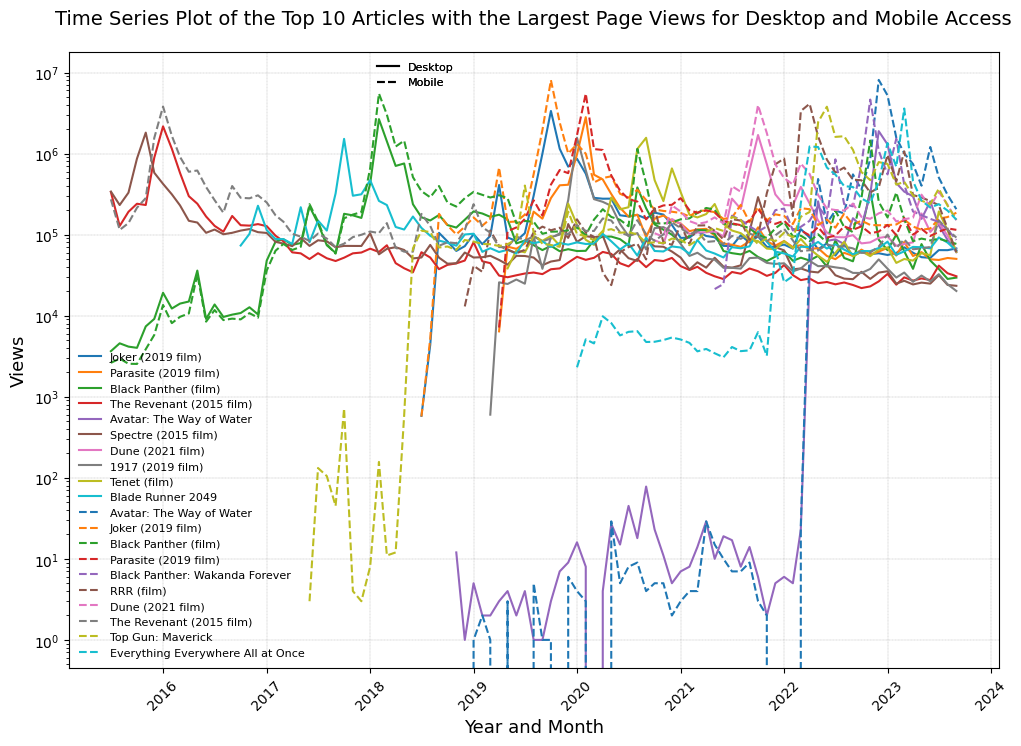

In [222]:
from matplotlib.lines import Line2D
import matplotlib.dates as mdates

# Create a figure and axis
plt.figure(figsize=(12, 8))
ax = plt.gca()

# Iterate through all the articles in desktop and mobile to plot the views as a timeseries graph
for desktop_article in desktop_top10_articles:
    desktop_article_result = desktop_df[desktop_df['article'] == desktop_article]
    ax.plot(desktop_article_result['timestamp'], desktop_article_result['views'], linestyle='-',
            label=desktop_article.replace('_', ' '))

for mobile_article in mobile_top10_articles:
    mobile_article_result = mobile_df[mobile_df['article'] == mobile_article]
    ax.plot(mobile_article_result['timestamp'], mobile_article_result['views'], linestyle='--',
            label=mobile_article.replace('_', ' '))

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Set axes labels and title with appropriate font size
plt.xlabel('Year and Month', fontsize=13)
plt.ylabel('Views', fontsize=13)
plt.title('Time Series Plot of the Top 10 Articles with the Largest Page Views for Desktop and Mobile Access', pad=20,
          fontsize=14)

# The first legend below represents all the article names
legend1 = plt.legend(loc='lower left', prop={"size": 8}, frameon=False)
ax.add_artist(legend1)

# The second legend groups the titles based on the two access types - desktop and mobile
linestyles = {'Desktop': '-', 'Mobile': '--'}
legend_lines = [Line2D([0], [0], color='black', linestyle=linestyle) for linestyle in linestyles.values()]
legend2 = ax.legend(legend_lines, linestyles.keys(), bbox_to_anchor=(0.425, 1), prop={"size": 8},
                    frameon=False)
ax.add_artist(legend2)

# Add gridlines
plt.grid(True, linestyle='--', color='gray', linewidth=0.2)

plt.setp(plt.gca().get_xticklabels(), rotation=45)
plt.show()

The objective here is to identify and plot the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access. Two dictionaries are created that contain the article name as the key and the number of months of data as the value for the desktop and mobile access types.

In [193]:
desktop_dict = dict()
mobile_dict = dict()
for movie in list(desktop_df['article']):
    if movie in desktop_dict.keys():
        desktop_dict[movie] += 1
    else:
        desktop_dict[movie] = 1

for mov in list(mobile_df['article']):
    if mov in mobile_dict.keys():
        mobile_dict[mov] += 1
    else:
        mobile_dict[mov] = 1

The dictionaries are sorted and the names of the the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access are identified and a subset of the orginal dataframe that contains the data for these movies is created.

In [196]:
desktop_to_plot_df_list = list(dict(sorted(desktop_dict.items(), key=lambda item: item[1])[0:10]).keys())
desktop_to_plot_df = desktop_df[desktop_df['article'].isin(desktop_to_plot_df_list)]

mobile_to_plot_df_list = list(dict(sorted(mobile_dict.items(), key=lambda item: item[1])[0:10]).keys())
mobile_to_plot_df = mobile_df[mobile_df['article'].isin(mobile_to_plot_df_list)]

The timeseries of the identified movies is plotted and labelled using the pyplot library.

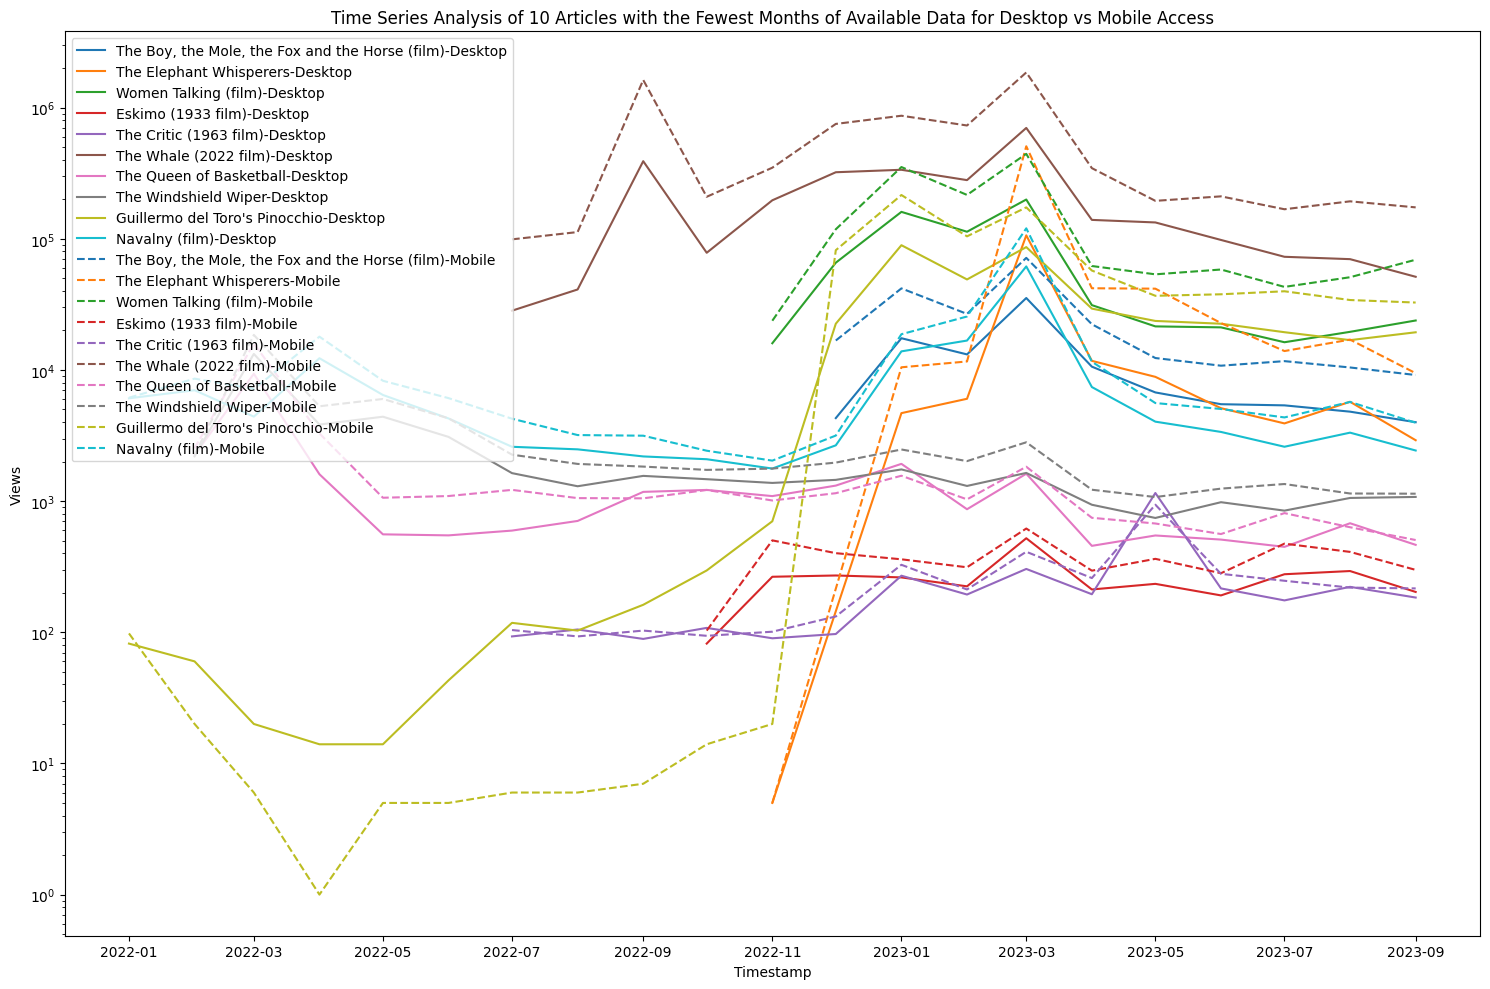

In [208]:
plt.figure(figsize = (15,10))

for i in desktop_to_plot_df_list:
    desktop_to_plot_df = desktop_df[desktop_df['article'] == i]
    plt.semilogy(desktop_to_plot_df['timestamp'], desktop_to_plot_df['views'], label=i.replace('_',' ')+'-Desktop')
for j in mobile_to_plot_df_list:
    mobile_to_plot_df = mobile_df[mobile_df['article'] == j]
    plt.semilogy(mobile_to_plot_df['timestamp'], mobile_to_plot_df['views'], linestyle = 'dashed', label=j.replace('_',' ')+'-Mobile')

plt.title('Time Series Plot of the 10 Articles with the Fewest Months of Data Available for Desktop vs Mobile Access')
plt.xlabel('Timestamp')
plt.ylabel('Views')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
